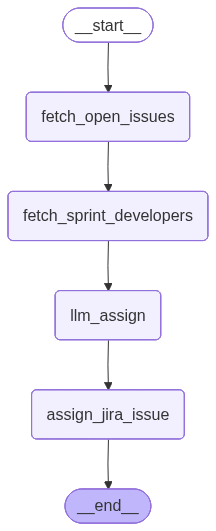

Pipeline finished: {'issues': [{'key': 'CRT-9294', 'title': 'CREATION FAILURE', 'description': 'Admin permission not working with groups - FMC Corporation'}], 'developers': {}, 'assignments': []}


In [1]:
# langgraph_pipeline.py
import os
import re
import requests
import json
from typing import Dict, Any, List, Tuple
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict
from IPython.display import Image, display

# ----------------------------
# Load env
# ----------------------------
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
JIRA_BASE_URL = "https://ca-il-jira.il.cyber-ark.com:8443"
BEARER_TOKEN = "xGkGLtKttyM5Gnr57XLyPYMg2k1RwpnTyBiR8P"
SPRINT_ID = "36339"

# ----------------------------
# Your State
# ----------------------------
class State(TypedDict):
    issues: List[Dict[str, Any]]
    developers: Dict[str, int]
    assignments: List[Tuple[str, str]]

# ----------------------------
# Tool 1: Fetch Open Issues
# ----------------------------
def fetch_open_issues(_: State) -> List[Dict[str, Any]]:
    JQL_QUERY = (
        'project = "Cross RND Ticket" AND type = Ticket '
        'AND component = Identity-Integrations AND status = "Investigating" '
    )
    API_ENDPOINT = f"{JIRA_BASE_URL}/rest/api/2/search"
    params = {
        "jql": JQL_QUERY,
        "fields": "summary,description,customfield_19321,customfield_16122",
        "maxResults": 50
    }
    headers = {
        "Authorization": f"Bearer {BEARER_TOKEN}",
        "Accept": "application/json"
    }
    resp = requests.get(API_ENDPOINT, headers=headers, params=params)
    issues = []
    if resp.status_code == 200:
        for issue in resp.json().get("issues", []):
            key = issue.get("key")
            fields = issue.get("fields", {})
            title = fields.get("customfield_19321", {}).get("value", "No Title")
            desc = fields.get("summary", "No Description")
            issues.append({"key": key, "title": title, "description": desc})
    return issues

# ----------------------------
# Tool 2: Fetch Sprint Developers
# ----------------------------
def fetch_sprint_developers(_: State) -> Dict[str, int]:
    url = f"{JIRA_BASE_URL}/rest/agile/1.0/sprint/{SPRINT_ID}/issue"
    headers = {"Authorization": f"Bearer {BEARER_TOKEN}", "Accept": "application/json"}
    resp = requests.get(url, headers=headers)
    developer_points: Dict[str, int] = {}
    if resp.status_code == 200:
        for issue in resp.json().get("issues", []):
            fields = issue.get("fields", {})
            status = fields.get("status", {}).get("name", "").lower()
            if status in ["done", "completed", "closed"]:
                continue
            assignee = fields.get("assignee", {}) or {}
            name = assignee.get("name", "Unassigned")
            sp = fields.get("customfield_11820", 0) or 0
            developer_points[name] = developer_points.get(name, 0) + sp
    return developer_points

# ----------------------------
# Tool 3: LLM Assignment
# ----------------------------
def llm_assign(state: State) -> List[Tuple[str, str]]:
    developers = state["developers"]
    issues = state["issues"]

    state_prompt = "".join(f"Developer: {d}, Points: {p}\n" for d, p in developers.items())
    issue_prompt = "".join(f"{i['key']}: {i['title']} | {i['description']}\n" for i in issues)

    llm = ChatOpenAI(
        openai_api_key=OPENAI_API_KEY,
        openai_api_base="https://openrouter.ai/api/v1",
        model="qwen/qwq-32b:free"
    )

    prompt = (
        state_prompt + issue_prompt +
        "Assign each CRT number to the developer with the fewest story points.\n"
        "Format strictly:\nCRT-xxxx: developer_name"
    )
    resp = llm.invoke(prompt)
    resp_text = resp.content.strip()
    assignments = []
    for line in resp_text.splitlines():
        m = re.match(r"^(CRT-\\d+):\\s+([\\w\\d_-]+)$", line.strip())
        if m:
            assignments.append((m.group(1), m.group(2)))
    return assignments

# ----------------------------
# Tool 4: Assign JIRA Issue
# ----------------------------
def assign_jira_issue(assignments: List[Tuple[str, str]]) -> None:
    for crt, dev in assignments:
        url = f"{JIRA_BASE_URL}/rest/api/2/issue/{crt}/assignee"
        headers = {"Content-Type": "application/json", "Authorization": f"Bearer {BEARER_TOKEN}"}
        payload = {"name": dev}
        r = requests.put(url, headers=headers, data=json.dumps(payload))
        if r.status_code == 204:
            print(f"Assigned {crt} -> {dev}")
        else:
            print(f"Failed {crt}: {r.status_code} {r.text}")

# ----------------------------
# Build LangGraph
# ----------------------------
graph = StateGraph(State)

graph.add_node("fetch_open_issues", lambda s: {"issues": fetch_open_issues(s)})
graph.add_node("fetch_sprint_developers", lambda s: {"developers": fetch_sprint_developers(s)})
graph.add_node("llm_assign", lambda s: {"assignments": llm_assign(s)})
graph.add_node("assign_jira_issue", lambda s: assign_jira_issue(s["assignments"]) or {})

graph.set_entry_point("fetch_open_issues")
graph.add_edge("fetch_open_issues", "fetch_sprint_developers")
graph.add_edge("fetch_sprint_developers", "llm_assign")
graph.add_edge("llm_assign", "assign_jira_issue")
graph.add_edge("assign_jira_issue", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

if __name__ == "__main__":
    final_state = app.invoke({})
    print("Pipeline finished:", final_state)